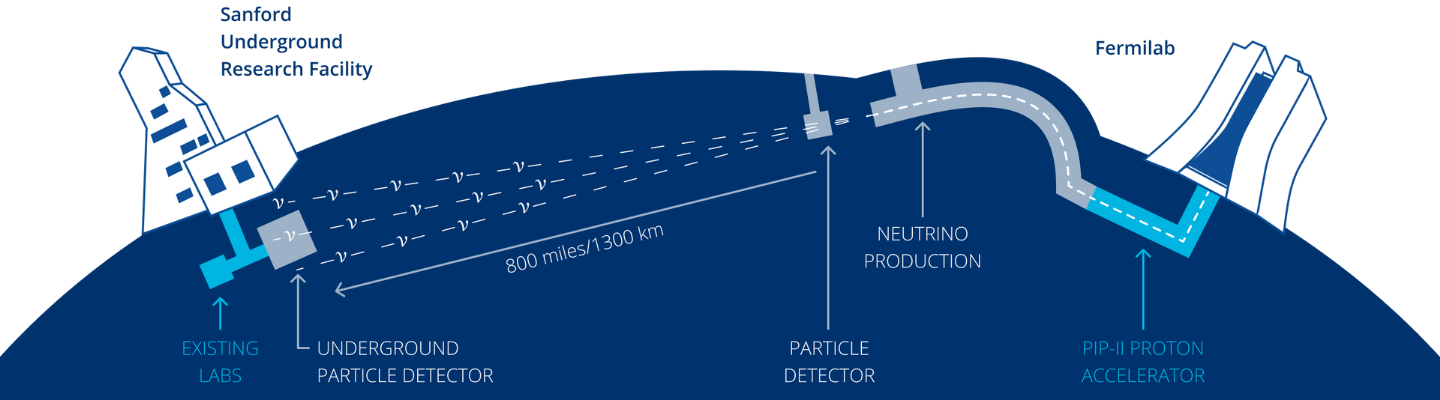

# <a id='toc1_'></a>[Explore  Simulated Muon Data](#toc0_)

We begin with a simplified Monte Carlo (MC) dataset containing muons simulated within the **PDHD detector**, to familirize with the data format and event display.

As you explore, consider the detector geometry and readout characteristics. Verify whether the observed data behavior aligns with the detector design and expected physical response. Also, note any indications of noise within the data.

🔍 Muons are used to calibrate the detector response because their tracks are long, clean, and well-understood. Muons also help characterize spallation backgrounds—when cosmic muons interact with argon and produce isotopes that mimic neutrino signals.

**Table of contents**<a id='toc0_'></a>    
- [Explore  Simulated Muon Data](#toc1_)    
  - [Loading the libraries and style of the notebook](#toc1_1_)    
  - [Global look to the MC data and detector response to it](#toc1_2_)    
  - [Looking into each plane activity and each APA activity](#toc1_3_)    
    - [Minimal cleaning and finding the best threshold](#toc1_3_1_)    
  - [Correlating Muon Energy with TP Activity](#toc1_4_)    
  - [Examine how Trigger Primitive (TP) properties](#toc1_5_)    
    - [Check orientation of these tracks](#toc1_5_1_)    
    - [How do the width and the height of our signal change with the angular direction?](#toc1_5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Loading the libraries, files and style of the notebook](#toc0_)

In [1]:
import warnings
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import HTML

In [2]:
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

# Constants
FILEPATH = "../data/muons_simtps_pdhd_n100.root"
TP_BRANCHES = [
    "event", "TP_channel", "TP_startT", "TP_peakT", "TP_peakADC", "TP_SADC", "TP_TOT", 
    "TP_plane", "TP_TPC", "TP_trueX", "TP_trueY", "TP_trueZ", "TP_signal"
]
MC_BRANCHES = ["event", "Eng", "Px", "Py", "Pz", "P"]
SADC_MIN = 2500
SADC_MAX = 20000
COLLECTION_PLANE = 2

with uproot.open(FILEPATH) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'n_TPs', 'n_noise_TPs_X', 'n_noise_TPs_U', 'n_noise_TPs_V', 'n_signal_TPs_X', 'n_signal_TPs_U', 'n_signal_TPs_V', 'totQ_X', 'totQ_U', 'totQ_V', 'detQ_X', 'detQ_U', 'detQ_V', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC', 'TP_trueX', 'TP_trueY', 'TP_trueZ', 'TP_signal', 'nParticles', 'TrackId', 'Mother', 'Pdg', 'Eng', 'Ekin', 'Mass', 'P', 'Px', 'Py', 'Pz', 'startX', 'startY', 'startZ', 'endX', 'endY', 'endZ']


In [3]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(FILEPATH, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(FILEPATH) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {FILEPATH}: {e}")
        return None

#--simulation data containing 100 single muon events in the ProtoDUNE Horizontal Drift Geometry (PDHD)
mc  = load_data(FILEPATH, MC_BRANCHES, 1000) #MC carlo output
tps  = load_data(FILEPATH, TP_BRANCHES, 1000)  #corresponding trigger primitive (TP) information

## <a id='toc1_2_'></a>[Global look to the MC data and detector response to it](#toc0_)

- Only higher-energy cosmic and atmospheric muons can penetrate to DUNE, all the others are beam muons.

- Px, Py (where x is the drift direction) is roughly simmetrical: no preference between up and down of the PDHD

- This is not a boosted beam, it's isotropic in nature so the Pz momentum makes sense.

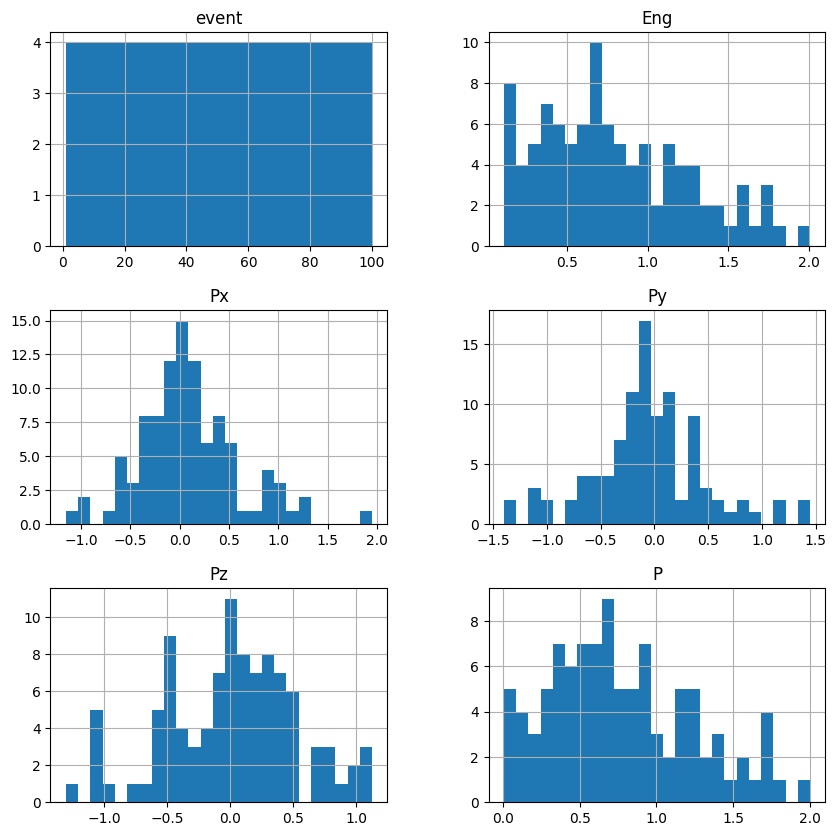

Eng mean: 0.79 and std deviation 0.46 GeV.
Px mean: 0.09 and std deviation 0.51 GeV.
Py mean: -0.05 and std deviation 0.53 GeV.
Pz mean: 0.01 and std deviation 0.53 GeV.


In [4]:
#MC data - note that the energies are in GeV
#Note: these are 100 events in 25 bins 
mc.hist(figsize= (10,10), bins =25)
plt.show()

print(f"Eng mean: {mc['Eng'].mean():.2f} and std deviation {mc['Eng'].std():.2f} GeV.")
print(f"Px mean: {mc['Px'].mean():.2f} and std deviation {mc['Px'].std():.2f} GeV.")
print(f"Py mean: {mc['Py'].mean():.2f} and std deviation {mc['Py'].std():.2f} GeV.")
print(f"Pz mean: {mc['Pz'].mean():.2f} and std deviation {mc['Pz'].std():.2f} GeV.")

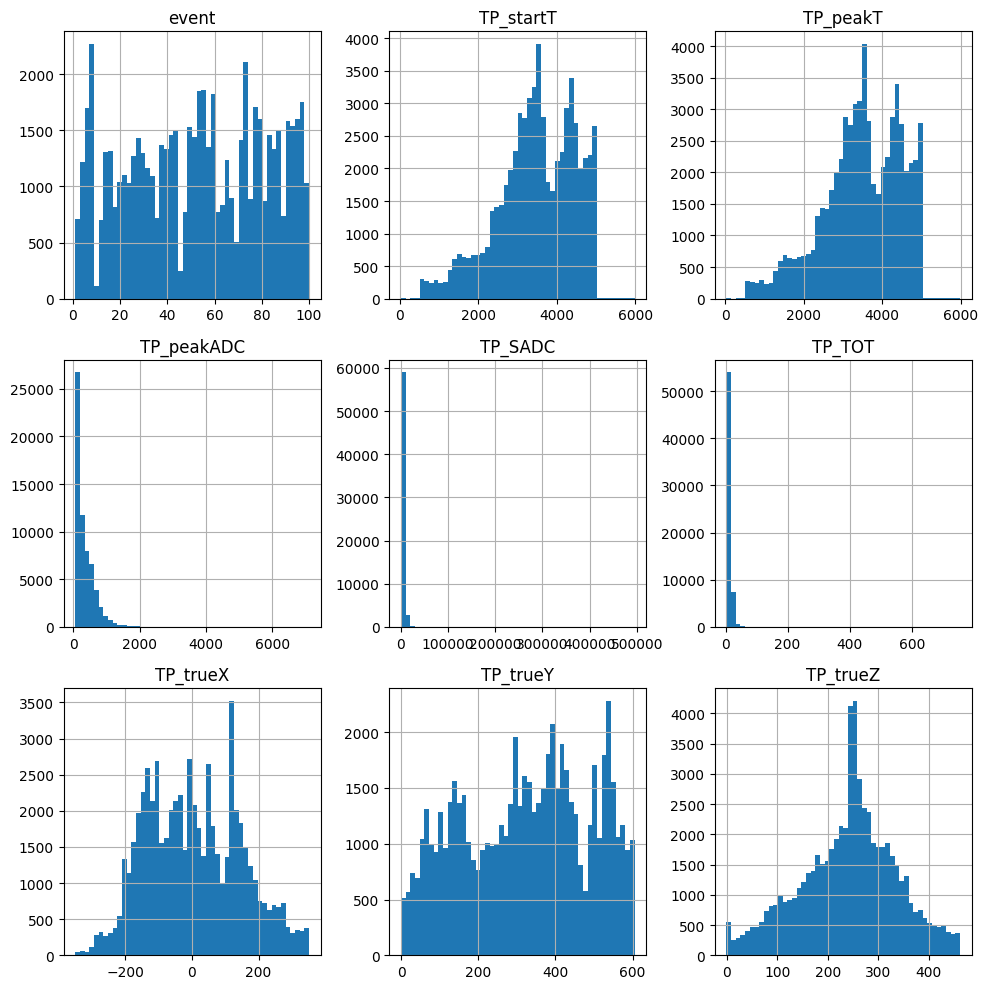

In [5]:
#TP data 
# Refers to the detector's response to simulated events
# This is the data you would "see" in the detector—i.e., the simulated output after the MC truth has passed through the detector simulation and signal processing.

#Collection plane: 960 vertical wires per side
#Induction planes: Two angled wire planes with 800 wires each, wrapping around both sides
ignore_cols = ["TP_channel", "TP_plane", "TP_TPC", "TP_signal"]
tps_filtered = tps.drop(columns=ignore_cols, errors='ignore')
tps_filtered[tps_filtered.TP_TOT > 2].hist(figsize=(10, 10), bins=50)
plt.tight_layout()
plt.show()
del tps_filtered

## <a id='toc1_3_'></a>[Looking into each plane activity and each APA activity](#toc0_)

More energy deposited by a particle → more ionization electrons → larger integrated signal (higher SADC).

There are calibration steps to convert SADC to true energy, but for summary and comparison, SADC is a good proxy for deposited energy. Check next cells 

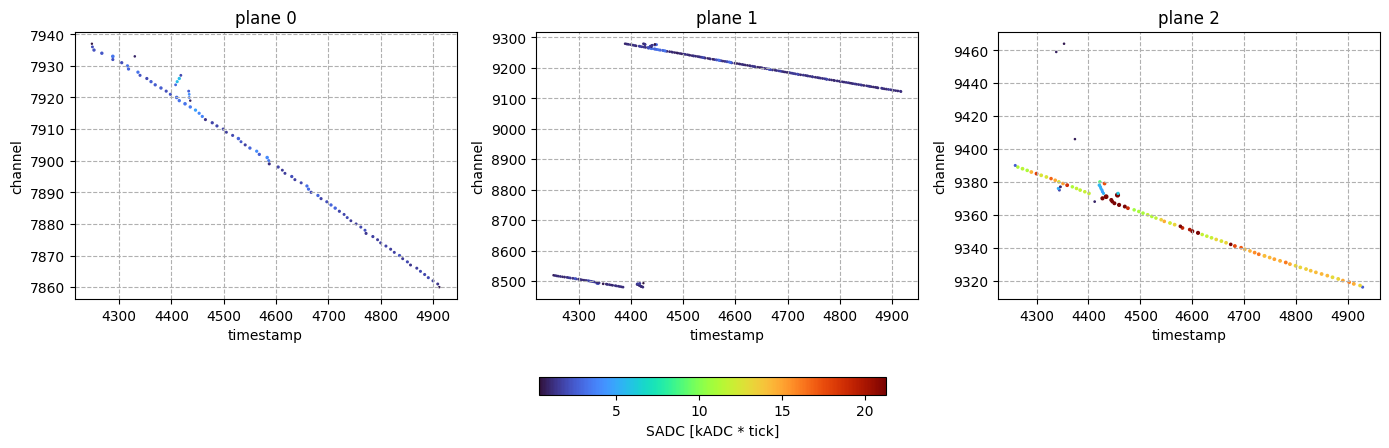

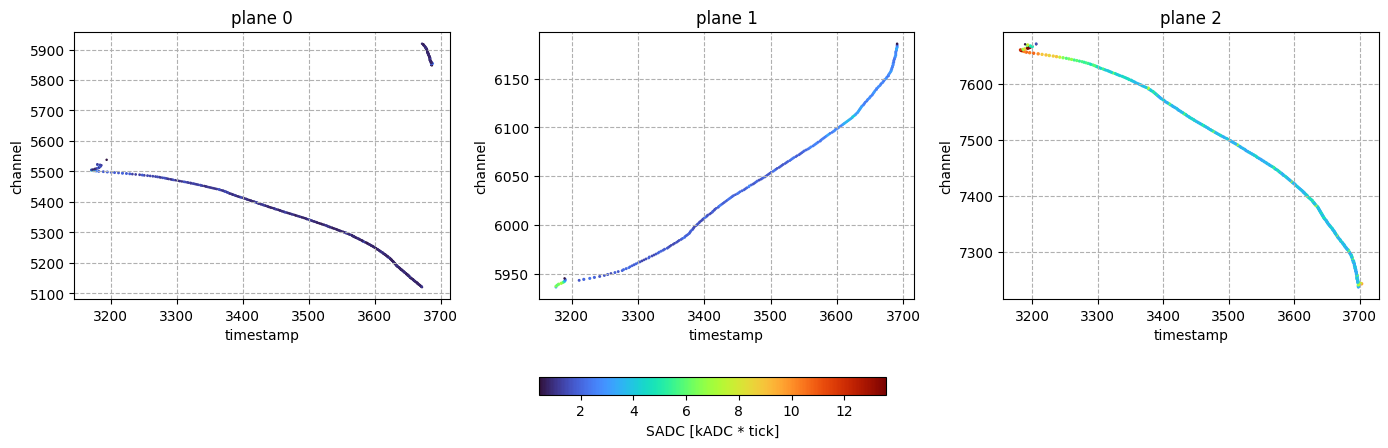

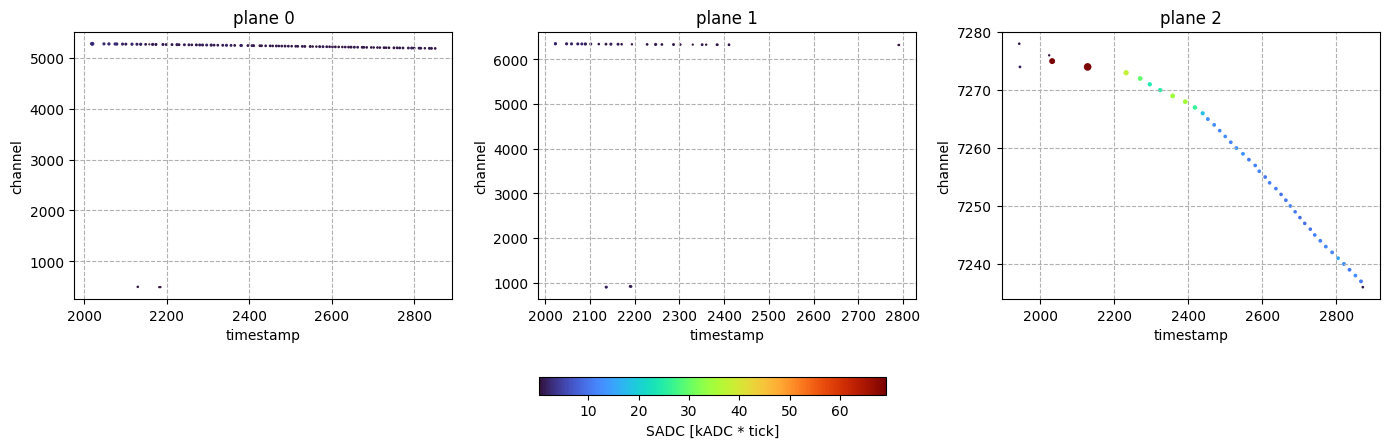

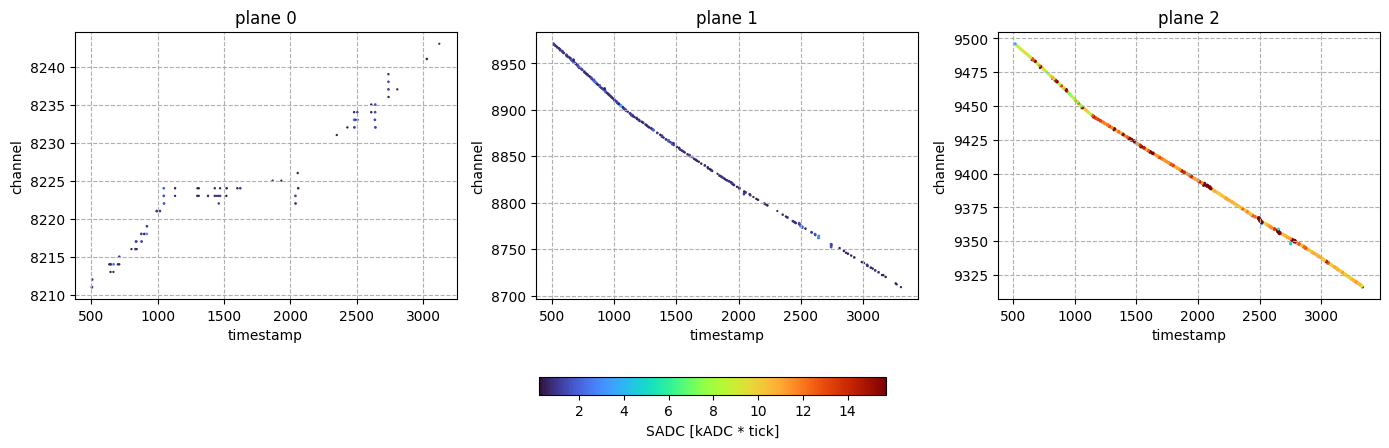

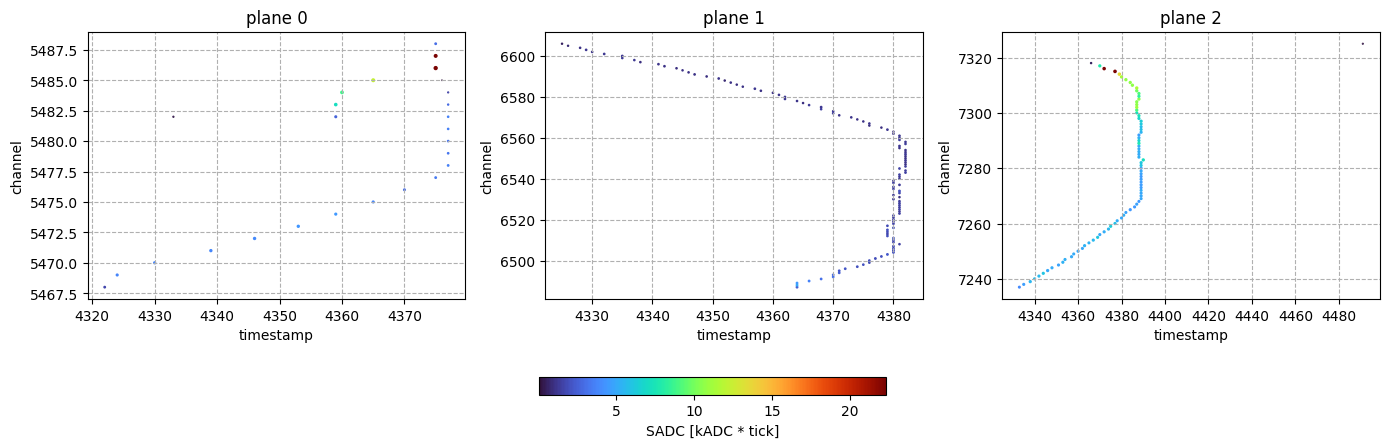

In [6]:
def Plot1DTracks_3planes(df, event, hit_threshold = 80):
    '''
    A function that let's you plot the trajectory of the muon in time-channel space, as seen within the detector for each readout wire plane.
    Increase the hit finding threshold if you're seeing noise in the data.
    '''

    tps_all = df[(df.event == event)  & (df.TP_peakADC > hit_threshold)]
    vmin, vmax = tps_all["TP_SADC"].min()/1e3, (tps_all["TP_SADC"].max()/1e3)/2

    fig, ax = plt.subplots(1, 3, figsize=(14, 4.5))

    for plane in range(3):
        tps = tps_all[tps_all.TP_plane == plane]
        sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
        ax[plane].set_xlabel("timestamp")
        ax[plane].set_ylabel("channel")
        ax[plane].set_title(f"plane {plane}")
        ax[plane].grid(linestyle='dashed')

    fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
    plt.tight_layout()
    plt.show()

Plot1DTracks_3planes(tps, 92)
Plot1DTracks_3planes(tps, 91)
Plot1DTracks_3planes(tps,90)
Plot1DTracks_3planes(tps, 80, hit_threshold=80)   #side effect of the induction plane, where the signal is a dual phase signal
Plot1DTracks_3planes(tps,60)#it's because probably there is an electron, candidate muon for decay

- You can clearly see that each track almost looks like it has one single color on the induction planes. Obv the SADC is higher on the collector plane.

- It also makes sense that the trajectory is about linear and goes through the channels of nearby APAs
    Cosmic muon ray do not stop for any reason, while candidate muon have a straight line and a final curvature are a muon decaying into electron (look at event 60)

- You can clearly see that there are some kind of steps in the event 80. This is just because of the dual phase of the waveforms and how their slightly cancelling each other in the y plane

### <a id='toc1_3_1_'></a>[Minimal cleaning and finding the best threshold](#toc0_)

In [7]:
def plot_TPC_activity(tps, thresholds=None, vmin=None, vmax=None, show_counts=True):
    """
    Plots TP activity per APA, on the collection plane.
    If thresholds is None, plots without cuts. Otherwise, loops over TP_TOT thresholds and plots for each.
    Also plots bar chart of TP counts per APA when show_counts is True (default).
    Note that APA 1 Collection plane is broken.
    """
    apa_ranges = {
        "APA1": (0, 2560),
        "APA3": (2560, 5120),
        "APA2": (5120, 7680),
        "APA4": (7680, 10240),
    }
    apa_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    title_prefix="TP Activity per APA"

    if thresholds is None:
        thresholds = [None]

    for thresh in thresholds:
        # Filter by threshold if specified
        if thresh is not None:
            filtered = tps[(tps.TP_plane==COLLECTION_PLANE) & (tps.TP_TOT > 8)]
            print(f"Threshold: {thresh} (TPs: {len(filtered)}, {len(filtered)/len(tps)*100:.2f}%)")
            plot_title = f"{title_prefix} (threshold: {thresh} [ticks])"
        else:
            filtered = tps[tps.TP_plane==COLLECTION_PLANE]
            plot_title = f"{title_prefix} (no cuts)"

        # --- Scatter plots ---
        fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
        for i, (apa, (start, stop)) in enumerate(apa_ranges.items()):
            ax = axs[i//2][i%2]
            df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
            sc = ax.scatter(
                df_apa.TP_peakT, df_apa.TP_channel,
                s=df_apa.TP_TOT / 10,
                c=df_apa.TP_SADC if thresh is not None else df_apa.TP_SADC / 1e3,
                cmap="viridis",
                alpha=0.7,
                edgecolor="none",
                vmin=vmin, vmax=vmax
            )
            ax.set_title(f"{apa} (channels {start}-{stop-1})")
            ax.set_xlabel("timestamp")
            ax.set_ylabel("TP_channel")
            ax.grid(True, linestyle="dotted", alpha=0.5)

        plt.suptitle(f"{plot_title} [channel vs. time]", fontsize=18)
        if thresh is not None:
            fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
        plt.show()

        # --- Bar plot: TP count per APA ---
        if show_counts:
            apa_counts = [
                len(filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)])
                for (start, stop) in apa_ranges.values()
            ]
            plt.figure(figsize=(8, 5))
            plt.bar(apa_ranges.keys(), apa_counts, color=apa_colors)
            plt.ylabel("Number of TPs")
            plt.title(f"Total TP Count per APA ({'threshold: ' + str(thresh) if thresh is not None else 'no cut'})")
            plt.show()

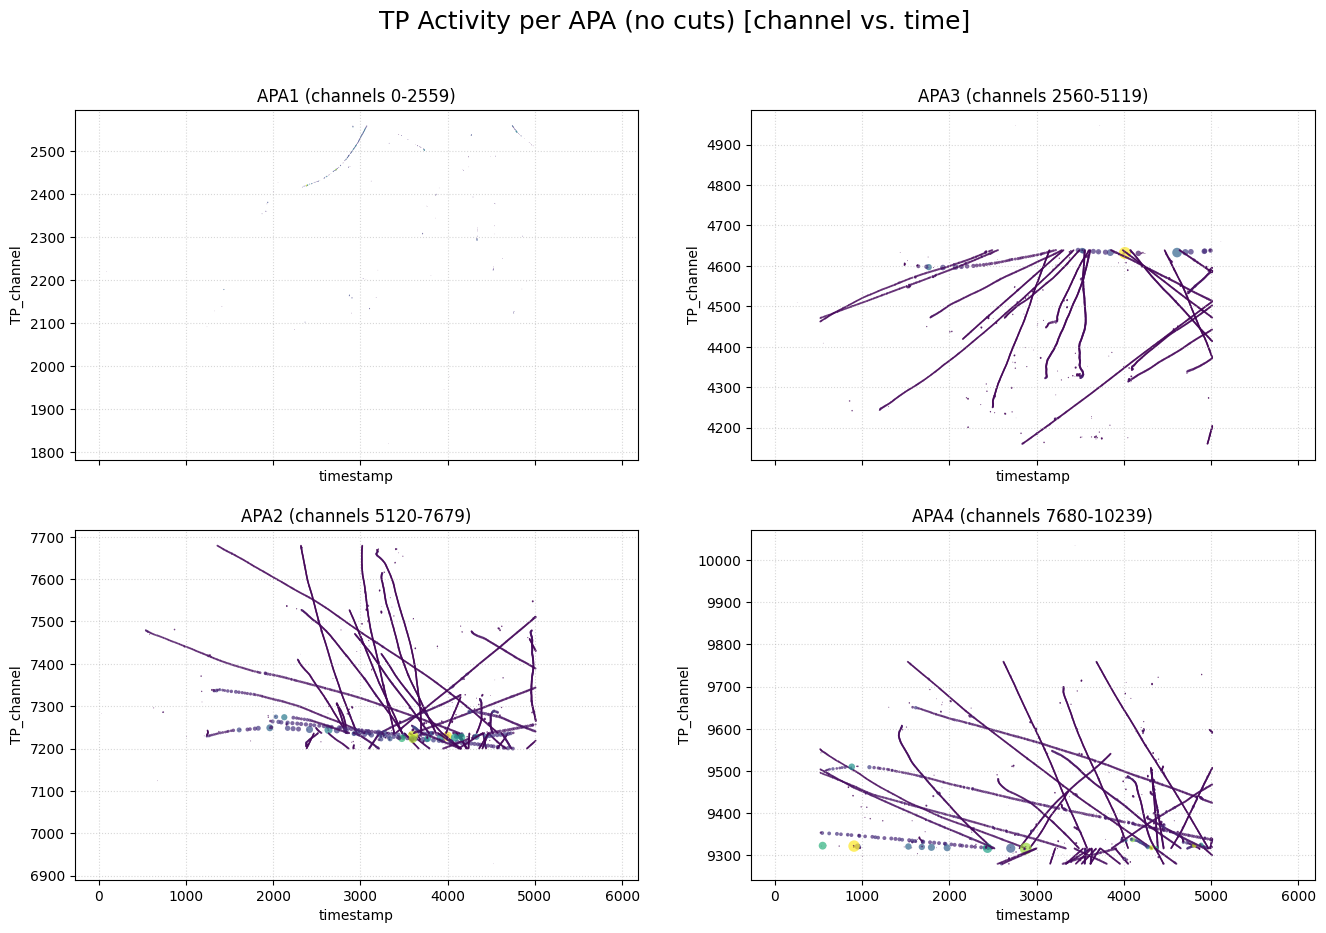

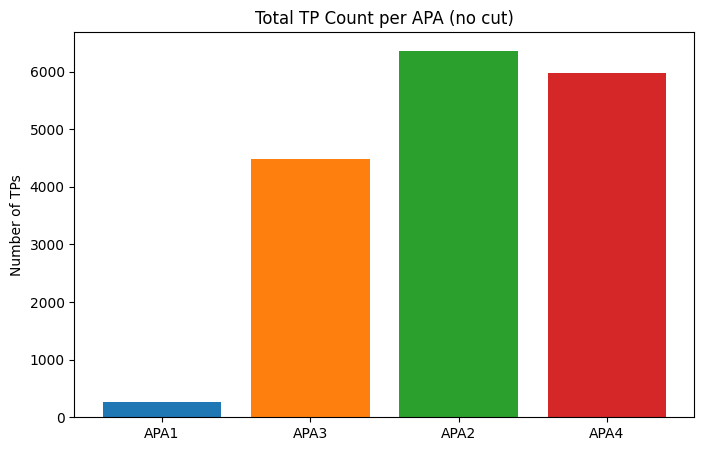

In [8]:
#no cuts
#In this picture you can see some noise (those thin straight lines), and almost everything in the same color.
#Note that APA1 is broken
plot_TPC_activity(tps)

High energy muons
Threshold: 8 (TPs: 16197, 19.90%)


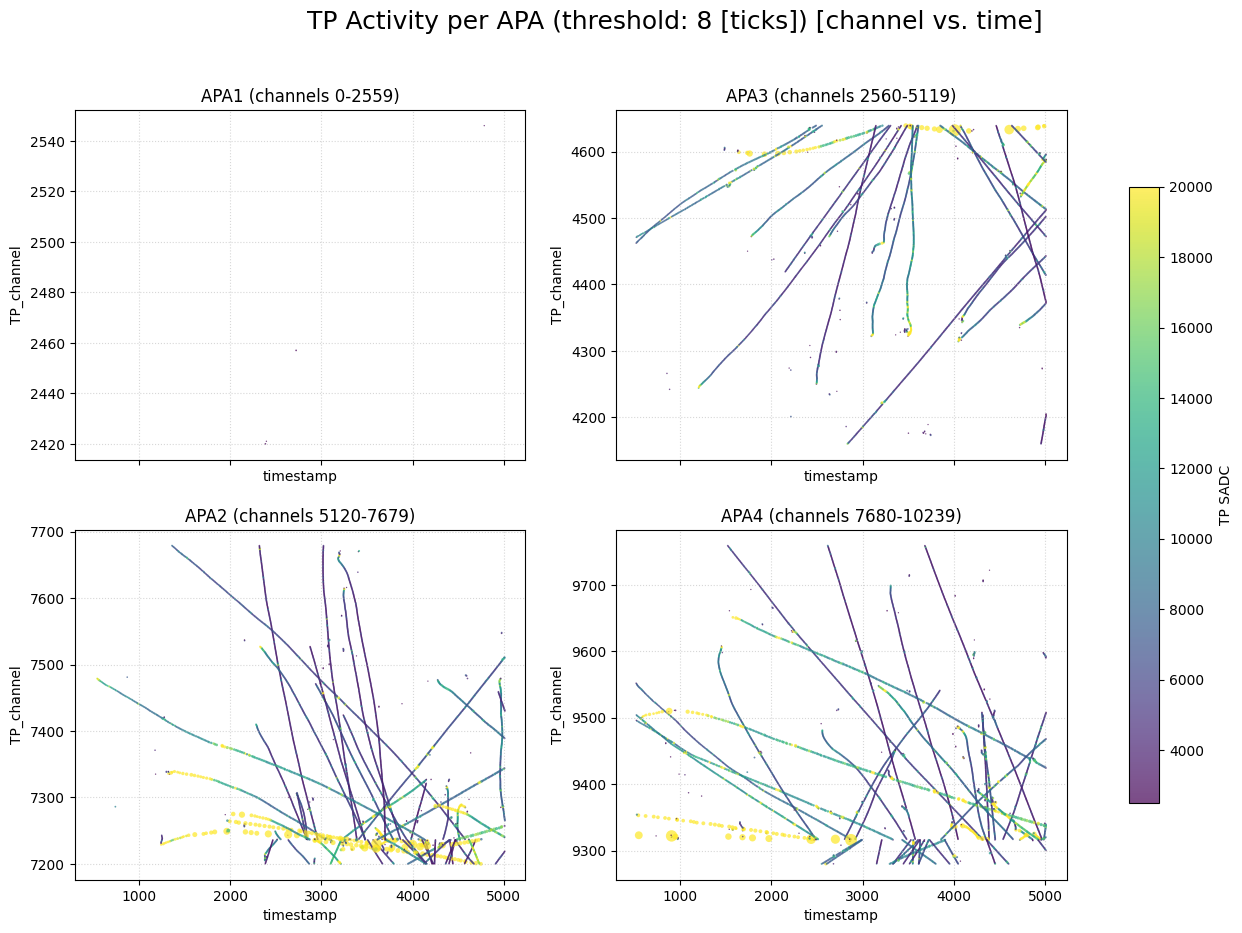

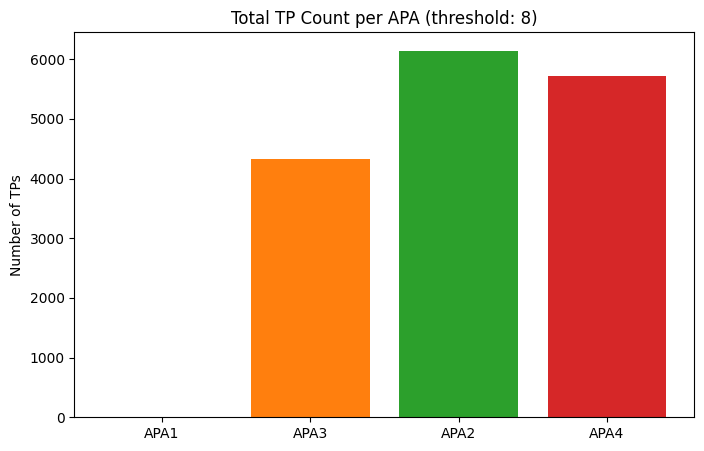

In [9]:
print("High energy muons")
plot_TPC_activity(tps, thresholds=[8], vmin=2500, vmax=20000)

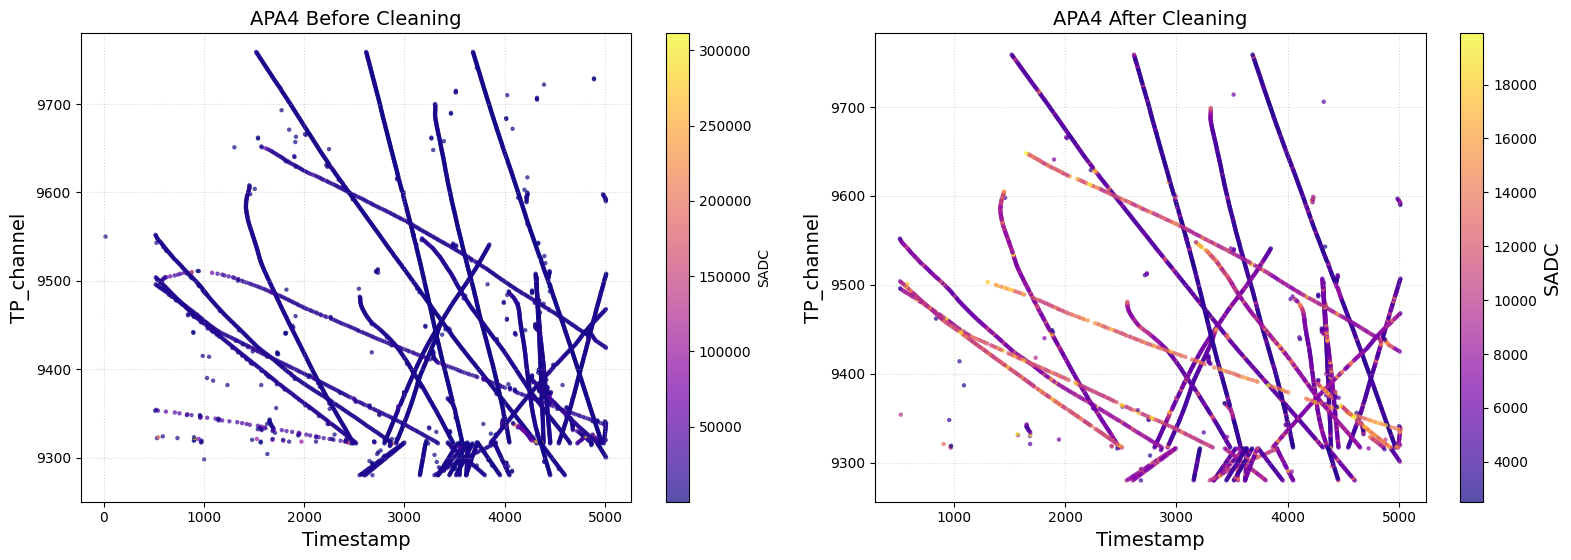

In [10]:
apa_name = "APA4"
start, stop = 7680, 10240

# --- BEFORE CLEANING: Mask for APA4, Collection Plane ---
apa4_mask = (
    (tps['TP_plane'] == COLLECTION_PLANE) &
    (tps['TP_channel'] >= start) & (tps['TP_channel'] < stop)
)

df_before = tps[apa4_mask]

# --- AFTER CLEANING: Apply SADC and peakADC cut ---
apa4_clean_mask = apa4_mask & (tps['TP_SADC'] >= SADC_MIN) & (tps['TP_SADC'] <= SADC_MAX) & (tps['TP_TOT'] > 2)
df_after = tps[apa4_clean_mask]

plt.figure(figsize=(16, 6))

# Before cleaning
plt.subplot(1, 2, 1)
sc1 = plt.scatter(
    df_before['TP_peakT'], df_before['TP_channel'],
    c=df_before['TP_SADC'], cmap='plasma', s=10, alpha=0.7, edgecolor="none"
)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("TP_channel", fontsize=14)
plt.title(f"{apa_name} Before Cleaning", fontsize=14)
cbar1 = plt.colorbar(sc1)
cbar1.set_label("SADC")
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.ylim(9250, 9780)  # Limita l’asse y

# After cleaning
plt.subplot(1, 2, 2)
sc2 = plt.scatter(
    df_after['TP_peakT'], df_after['TP_channel'],
    c=df_after['TP_SADC'], cmap='plasma', s=10, alpha=0.7, edgecolor="none"
)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("TP_channel", fontsize=14)
plt.title(f"{apa_name} After Cleaning", fontsize=14)
cbar2 = plt.colorbar(sc2)
cbar2.set_label("SADC", fontsize=14)
plt.grid(True, linestyle="dotted", alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

- It's clear that most of the tracks are above 480 SADC. The relative loss in TPs decreases extremely after thr=280, so it doesn't make any sense to go above that threshold, unless you want to concentrate on the VHE muons (probably in the center of the beam).

- If the track is uniform in color, you have a constant deposit. → If it varies along the track, it could indicate progressive energy loss (e.g. muon stopping) or angular variation.

- The bright yellow dots, are just muons that interact for a prolonged period of time with one wire, producing these high energy peaks. This correspondes to theta_xy=90°

- APA2 seems to be the noisest for some reason


In [11]:
def find_optimal_TPC_threshold(tps, min_thresh, max_thresh, step, delta_percent=2.0):
    """
    Finds the optimal TP_TOT threshold such that the relative decrease in TPs becomes negligible.
    Returns the first threshold for which the percent of lost TPs in the selection to respect to the previous threshold is < delta_percent.
    """
    total = len(tps)
    prev_percent = 0
    thresholds = np.arange(min_thresh, max_thresh+step, step) # the max_thresh+step is just because otherwise the last threshold would not be included in the comparison
    for thresh in thresholds:
        filtered_count = (tps.TP_TOT > thresh).sum()
        percent_lost = 100 * (total - filtered_count) / total
        percent_diff = percent_lost - prev_percent
        print(f"Thresh: {thresh:4d} | Lost: {percent_lost:6.2f}% | Delta: {percent_diff:6.2f}%")
        if thresh > min_thresh and abs(percent_diff) < delta_percent:
            return prev_thresh, prev_percent
        prev_percent = percent_lost
        prev_thresh = thresh
    return thresholds[-1], 100 * (total - (tps.TP_TOT > thresholds[-1]).sum())/total

optimal_thresh, percent = find_optimal_TPC_threshold(tps, min_thresh=0, max_thresh=10, step=1)
print(f"Optimal threshold: {optimal_thresh} (percent lost: {percent:.2f}%)")

Thresh:    0 | Lost:   0.00% | Delta:   0.00%
Thresh:    1 | Lost:  18.66% | Delta:  18.66%
Thresh:    2 | Lost:  23.54% | Delta:   4.88%
Thresh:    3 | Lost:  25.03% | Delta:   1.49%
Optimal threshold: 2 (percent lost: 23.54%)


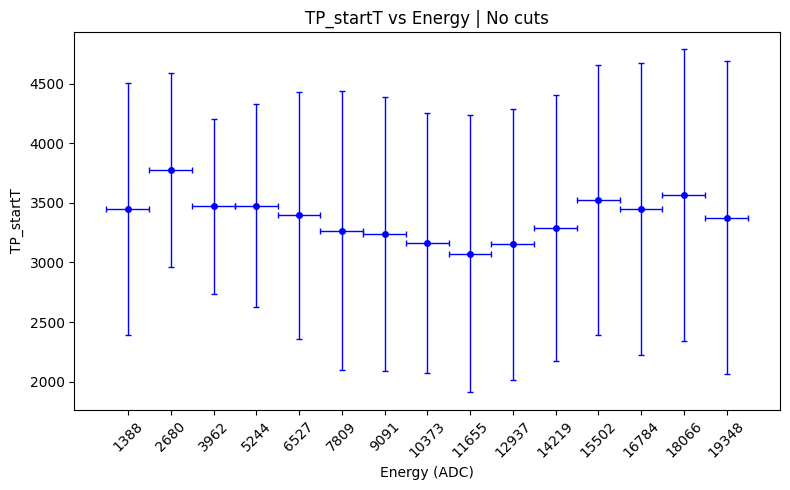

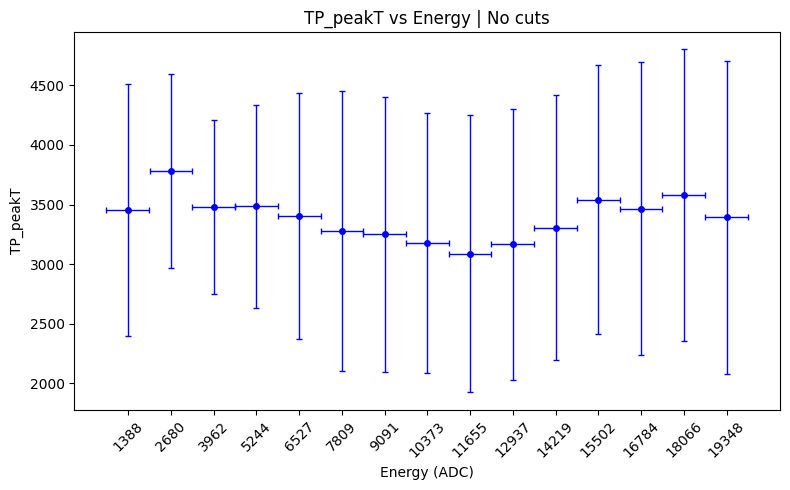

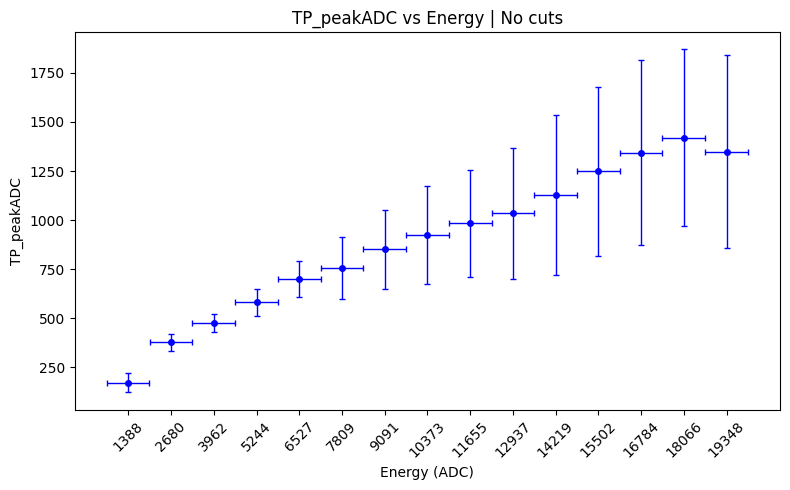

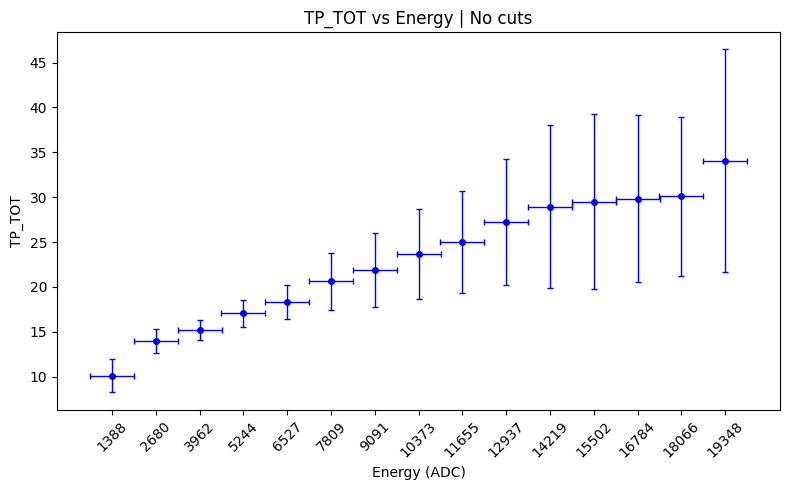

In [12]:
def plot_tp_properties_vs_energy( df, cuts=None, bins=15, properties=None):
    """
    Plot TP properties vs energy for the collection plane.

    - cuts: list of dicts with keys: energy_min, energy_max, threshold, label
      If None, defaults to a single cut: energy_min=400, energy_max=1000, threshold=0, label="No cuts"
    - properties: list of column names to plot; if None, auto-selects numerical columns except ignored.
    """

    # Default cuts if not provided
    if cuts is None:
        cuts = [
            dict(energy_min=750, energy_max=20000, threshold=2, label="No cuts")
        ]

    colors = ['blue', 'orange', 'green', 'magenta', 'red', 'cyan']
    markers = ['o', 's', '^', 'v', 'D', 'x']

    # Ignore columns not relevant for plotting
    ignore_cols = {"TP_SADC", "TP_plane", "event", "TP_channel", "TP_TPC",
                   "TP_trueX", "TP_trueY", 'TP_trueZ', 'TP_signal'}
    
    if properties is None:
        properties = [col for col in df.columns
                      if (col not in ignore_cols and np.issubdtype(df[col].dtype, np.number))]
    if "TP_TOT" not in properties and "TP_TOT" in df.columns:
        properties.append("TP_TOT")

    # Plotting
    for prop in properties:
        plt.figure(figsize=(8, 5))
        for i, cut in enumerate(cuts):
            mask = (
                (df["TP_plane"] == COLLECTION_PLANE) &
                (df['TP_TOT'] > cut.get('threshold', 2)) &
                (df["TP_SADC"] >= cut.get('energy_min', 400)) &
                (df["TP_SADC"] <= cut.get('energy_max', 1000))
            )
            df_filt = df[mask].copy()
            if df_filt.empty:
                print(f"No data for cut: {cut.get('label', str(cut))}")
                continue
            # Bin by energy
            df_filt['energy_bin'] = pd.cut(df_filt["TP_SADC"], bins=bins)
            bin_centers = df_filt['energy_bin'].apply(lambda x: (x.left + x.right) / 2)
            df_filt['energy_bin_center'] = bin_centers
            energy_bin_width = (cut.get('energy_max', 1000) - cut.get('energy_min', 400)) / bins

            grouped = df_filt.groupby('energy_bin_center')[prop]
            means = grouped.mean()
            stds = grouped.std()
            centers = means.index.values
            counts = grouped.count()

            plt.errorbar(
            centers, means,
            xerr=energy_bin_width / 2,
            yerr=stds,
            fmt=markers[i % len(markers)],
            capsize=2,
            color=colors[i % len(colors)],
            ecolor=colors[i % len(colors)],
            elinewidth=1,
            markersize=4,
            label=f"{cut['label']} (n={int(counts.sum())})"
            )
            plt.title(f"{prop} vs Energy | {cut['label']}")
            plt.xlabel("Energy (ADC)")
            plt.ylabel(prop)
            plt.xticks(centers, [f"{c:.0f}" for c in centers], rotation=45)
            plt.tight_layout()
            plt.show()

# Single cut (as before)
plot_tp_properties_vs_energy(tps)

## <a id='toc1_4_'></a>[Correlating Muon Energy with TP Activity](#toc0_)


This part of the analysis focuses on how the energy of the muon correlates with the total visible energy recorded by the TPs, particularly in the **collection plane (plane 2)**, which is often the most signal-rich. 

Basically the reconstruction over the collection gets worse at the energy of the muon gets bigger

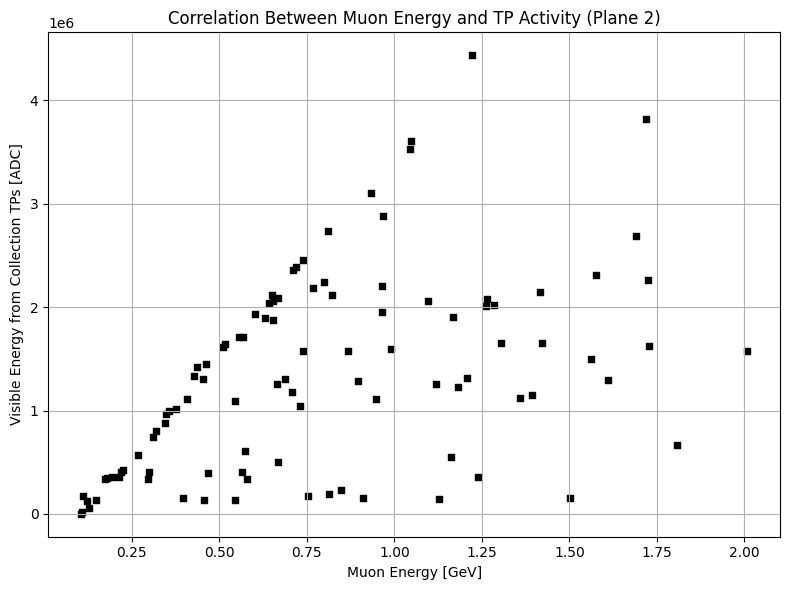

In [13]:
# Select only Trigger Primitives from the collection plane (plane ID == 2)
tp_plane2 = tps[tps.TP_plane == COLLECTION_PLANE]

# Identify unique event IDs that have activity in plane 2
# (This helps exclude events where the muon left the detector without passing through the active volume - hence producing no visible energy)
events_with_tp_activity = tp_plane2['event'].unique()

# From the MC dataset, select only those events that had visible TP activity and extract the corresponding muon energy values
muon_energy = mc[mc['event'].isin(events_with_tp_activity)].set_index('event')['Eng']

# Sum up the energy from all the collection TPs for each event 
visible_energy = tp_plane2.groupby('event')['TP_SADC'].sum() 

# Plot the correlation
plt.figure(figsize=(8, 6))
plt.scatter(muon_energy, visible_energy, s=20, c='k', marker='s')
plt.xlabel("Muon Energy [GeV]")
plt.ylabel("Visible Energy from Collection TPs [ADC]")
plt.title("Correlation Between Muon Energy and TP Activity (Plane 2)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
def plot_induction_plane_SADC(tps, mc, planes=(0, 1)):
    """
    Overlay correlation between Muon Energy and Visible TP Energy for multiple induction planes.
    """
    colors = ['darkgreen', 'darkred']
    markers = ['o', 's']

    plt.figure(figsize=(8, 6))
    for i, induction_plane in enumerate(planes):
        tp_induction = tps[tps.TP_plane == induction_plane]
        events_with_tp_activity = tp_induction['event'].unique()
        muon_energy = mc[mc['event'].isin(events_with_tp_activity)].set_index('event')['Eng']
        visible_energy = tp_induction.groupby('event')['TP_SADC'].sum()

        # Align muon_energy and visible_energy by event index
        muon_energy, visible_energy = muon_energy.align(visible_energy, join='inner')

        plt.scatter(muon_energy, visible_energy,
                    s=20,
                    c=colors[i % len(colors)],
                    marker=markers[i % len(markers)],
                    label=f"Induction Plane {induction_plane}",
                    alpha=0.7)

    plt.xlabel("Muon Energy [GeV]")
    plt.ylabel("Visible Energy from Induction TPs [ADC]")
    plt.title("Muon Energy vs TP Activity (Induction Planes Overlay)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

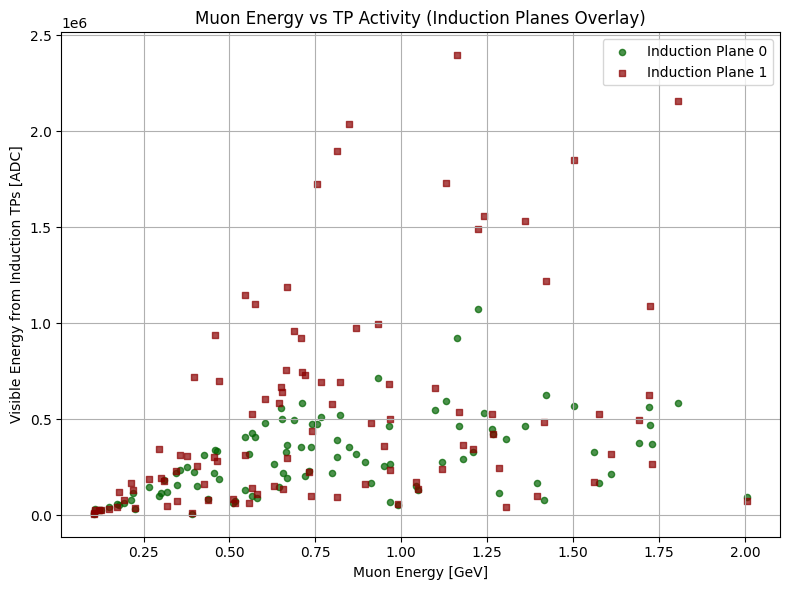

In [15]:
# Usage:
plot_induction_plane_SADC(tps, mc)

- Compared to the graph seen for the collection plane, here the linear combination between muon energy and visible energy from the TPs is  weaker.
    - Very wide dispersion and lower visible energy.
    - Induction plane 1 shows greater dispersion and higher maximum values, which may suggest greater sensitivity to noisy signals or less effective reconstruction of the TPs.
    - Induction TPs are weaker, last less, and collect less charge, so the total sum is more sensitive to fluctuations, noise, and threshold inefficiencies.

## <a id='toc1_5_'></a>[Examine Trigger Primitive (TP) properties](#toc0_)

For this part of the analysis we are going to concentrate only on the collection plane.

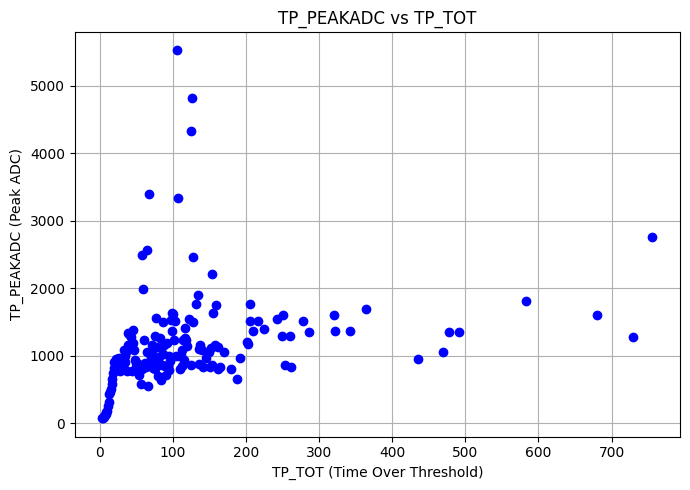

In [16]:
def plot_TP_PEAKADC_over_TP_TOT(df):
    """
    Plots the mean and standard deviation of TP_PEAKADC (Peak ADC) as a function of TP_TOT (Time Over Threshold)
    for trigger primitives in the specified collection plane.

    The function filters for rows where TP_TOT > 2, then groups the data by TP_TOT.
    If no data is found after filtering, a message is printed and no plot is produced.
    """
    mask = (
        (df["TP_plane"] == COLLECTION_PLANE) &
        (df['TP_TOT'] > 2)
    )
    df_filt = df[mask].copy()
    
    if df_filt.empty:
        print("No data after filtering.")
        return

    grouped = df_filt.groupby('TP_TOT')['TP_peakADC']
    means = grouped.mean()
    stds = grouped.std()
    tots = means.index.values

    plt.figure(figsize=(7,5))
    plt.errorbar(
        tots,        
        means,        
        fmt='o', 
        capsize=2, 
        color='blue', 
        ecolor='black'
    )
    plt.xlabel("TP_TOT (Time Over Threshold)")
    plt.ylabel("TP_PEAKADC (Peak ADC)")
    plt.title("TP_PEAKADC vs TP_TOT")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_TP_PEAKADC_over_TP_TOT(tps)

- The distributions of TP_PEAK and TP_Start are similar because, in most cases, the signal maximum and its onset occur almost simultaneously, especially for narrow pulses. It could also be the artifact of the TP algoritm.

- TP_TOT is the TIME OVER THRESHOLD, so the width of the signal chosen.  TP_PEAKADC is the maximum value registered.
    We have long stable low energy loss tracks and high energy tracks really short in time, probably due to the orientation of the muon.


In [17]:

def plot_collection_plane_prop(tps):
    """
    Create 3 scatter plots of channel hits on the collection plane as a function of timestamp.
    Each plot uses a colorbar to indicate a different property: Peak_ADC, SADC, and TOT.
    Only includes hits with SADC between SADC_MIN and SADC_MAX (default: 2500-20000).
    """
    apa_ranges = {
        "APA1": (0, 2560),
        "APA3": (2560, 5120),
        "APA2": (5120, 7680),
        "APA4": (7680, 10240),
    }
    properties = [
        ('TP_peakADC', 'Peak ADC', 'viridis'),
        ('TP_SADC', 'SADC', 'plasma'),
        ('TP_TOT', 'TOT', 'cividis'),
    ]
    for apa_name, (start, stop) in apa_ranges.items():
        # Filter for collection plane, APA range, and SADC range
        mask = (
            (tps['TP_plane'] == COLLECTION_PLANE) &
            (tps['TP_channel'] >= start) & (tps['TP_channel'] < stop) &
            (tps['TP_TOT'] > 2) &
            (tps['TP_SADC'] >= SADC_MIN) & (tps['TP_SADC'] <= SADC_MAX)
        )
        df = tps[mask]
        if df.empty:
            print(f"No data in SADC range for {apa_name} (channels {start}-{stop-1}).")
            continue
        plt.figure(figsize=(20, 5))
        for i, (col, label, cmap) in enumerate(properties, 1):
            plt.subplot(1, 3, i)
            sc = plt.scatter(
                df['TP_peakT'], df['TP_channel'],
                c=df[col], cmap=cmap, s=10, alpha=0.7, edgecolor="none"
            )
            plt.xlabel("Timestamp")
            plt.ylabel("TP_channel")
            plt.title(f"{apa_name}: {label}")
            cbar = plt.colorbar(sc)
            cbar.set_label(label)
            plt.grid(True, linestyle="dotted", alpha=0.5)
        plt.suptitle(f"{apa_name} (channels {start}-{stop-1}) Collection Plane Hits (SADC {SADC_MIN}-{SADC_MAX})", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

No data in SADC range for APA1 (channels 0-2559).


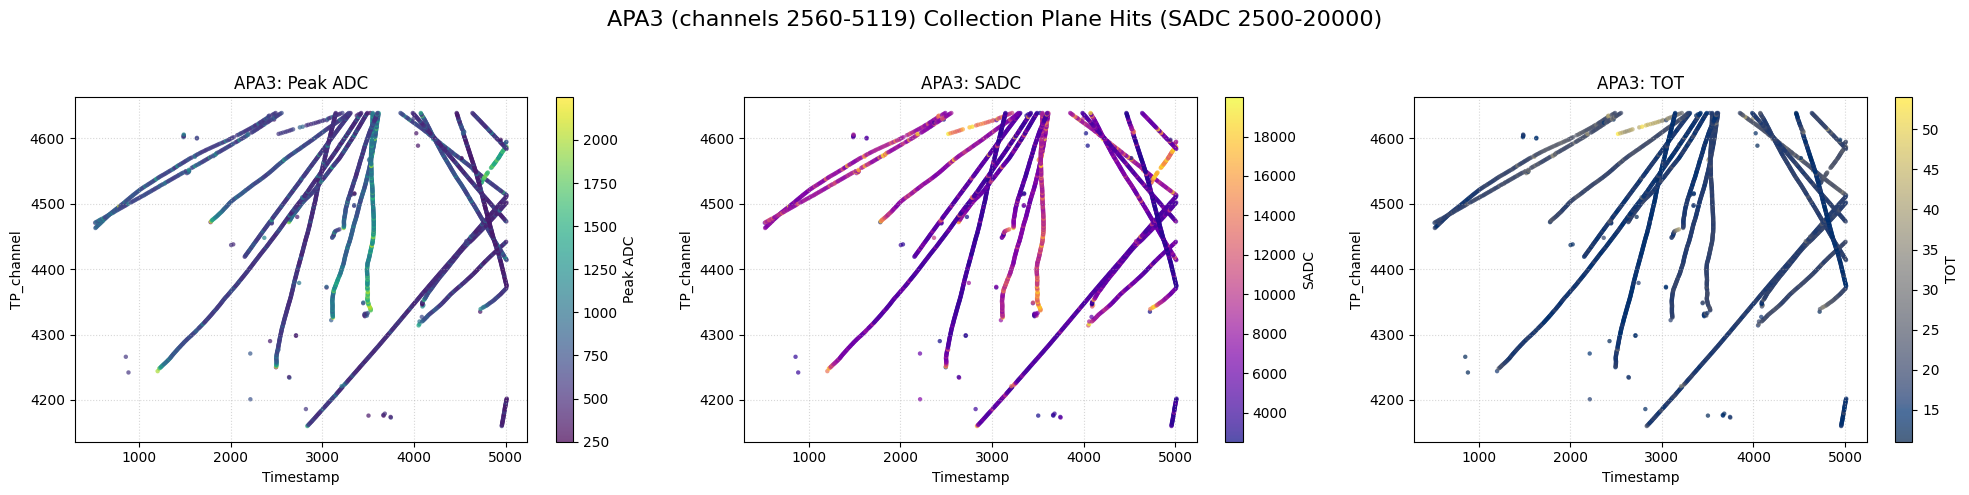

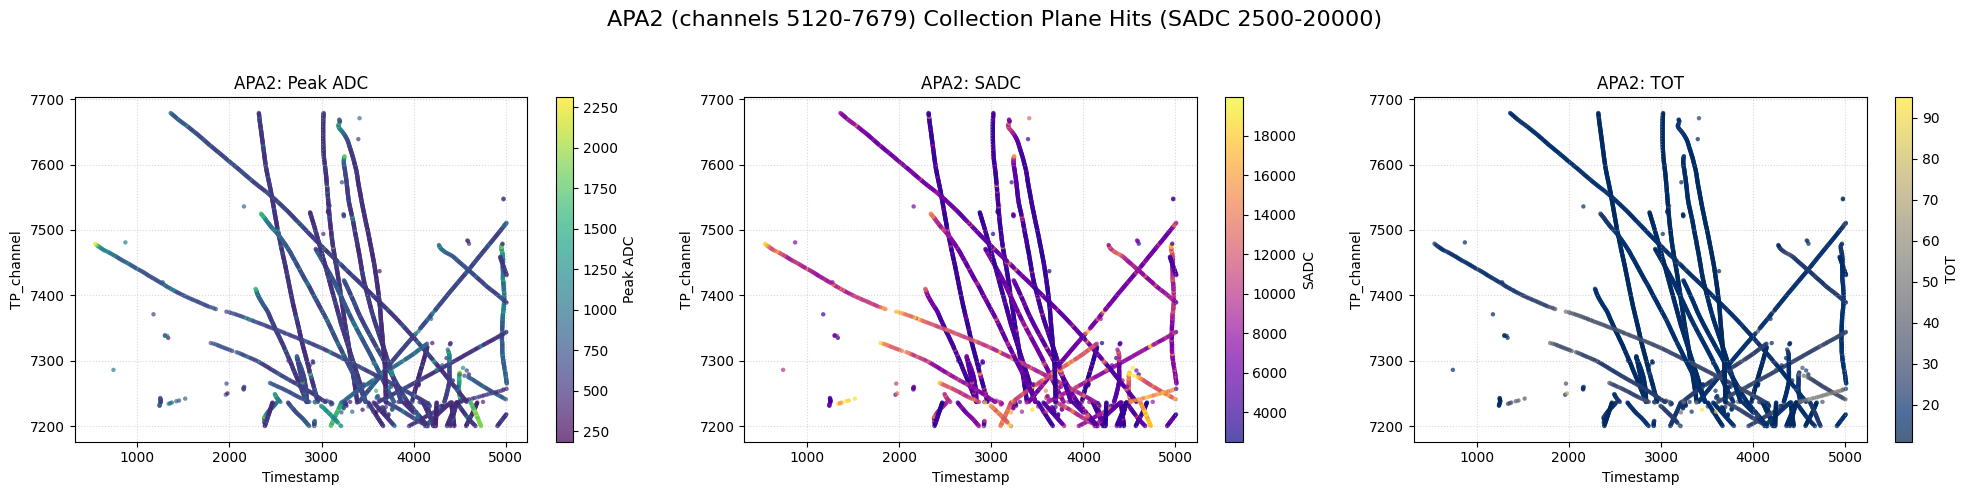

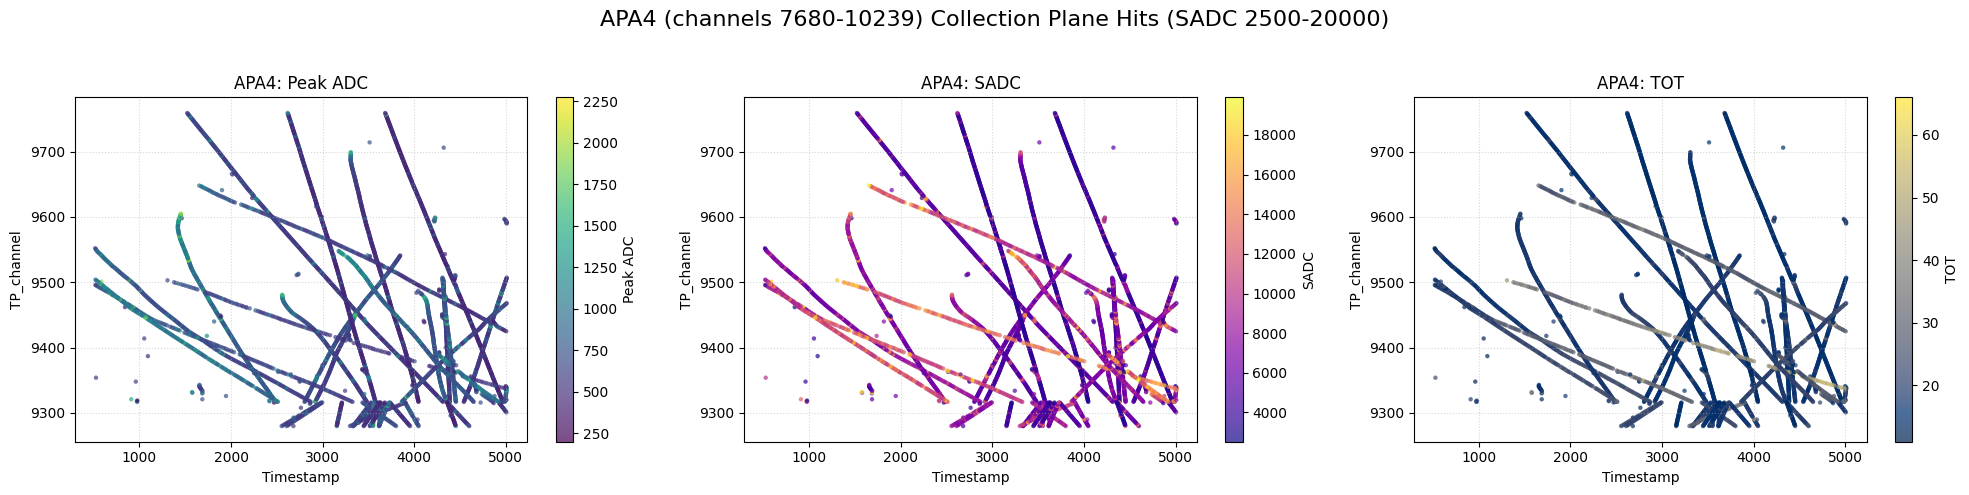

In [18]:
plot_collection_plane_prop(tps)

### <a id='toc1_5_1_'></a>[Check orientation of these tracks](#toc0_)

In [19]:

def calculate_angles(px, py, pz, p_mag):   
    """
    Compute θ_y (angle w.r.t vertical y-axis, with θ_y = 0),
    θ_U (angle w.r.t U-plane wires at +37.5°),
    θ_V (angle w.r.t V-plane wires at -37.5°),
    θ_xz (angle in drift-beam xz-plane),
    and θ_xz for rotated U and V planes.
    """
    #we are going to consider the y axis upward in this function
    theta_y = np.degrees(np.arccos(py / p_mag)) #information from the MC data
    theta_xz = np.degrees(np.arctan2(px, pz))

    theta_rot_U = np.radians(-37.5)
    theta_rot_V = np.radians(37.5)

    # Rotate moment for U-plane, btw this is what I got wrong in the previous code!! 
    p_y_U = py * np.cos(theta_rot_U) - pz * np.sin(theta_rot_U)
    p_z_U = py * np.sin(theta_rot_U) + pz * np.cos(theta_rot_U)
    theta_xz_U = np.degrees(np.arctan2(px, p_z_U))
    theta_y_U = 90 - np.degrees(np.arcsin(p_y_U / p_mag))

    # Rotate for V-plane
    p_y_V = py * np.cos(theta_rot_V) - pz * np.sin(theta_rot_V)
    p_z_V = py * np.sin(theta_rot_V) + pz * np.cos(theta_rot_V)
    theta_xz_V = np.degrees(np.arctan2(px, p_z_V))
    theta_y_V = 90 - np.degrees(np.arcsin(p_y_V / p_mag))

    return theta_y, theta_y_U, theta_y_V, np.abs(theta_xz), np.abs(theta_xz_U), np.abs(theta_xz_V)

theta_y, theta_y_U, theta_y_V, theta_xz, theta_xz_U, theta_xz_V = calculate_angles(
    mc['Px'].values, mc['Py'].values, mc['Pz'].values, mc['P'].values
)

mc['theta_y'] = theta_y
mc['theta_yU'] = theta_y_U
mc['theta_yV'] = theta_y_V
mc['theta_xz'] = theta_xz
mc['theta_xzU'] = theta_xz_U
mc['theta_xzV'] = theta_xz_V

In [20]:
def Plot_orientation(ax, df, mc, event):
    x = df[(df.event == event) & (df.TP_plane == 2)]

    s = ax[0].scatter(
        x.TP_trueZ, x.TP_trueX, c=x.TP_SADC, s=x.TP_TOT / 20,
        linewidth=1.3, cmap='jet',
        label=fr'$\theta_y$={int(mc[mc.event == event].theta_y.values[0])}°' + "\n" +
              fr'$\theta_{{xz}}$={int(mc[mc.event == event].theta_xz.values[0])}°',
        vmin=5e3, vmax=200e3
    )
    ax[0].set_ylabel("x [cm]")
    ax[0].set_xlabel("z [cm]")
    plt.colorbar(s, ax=ax[0])

    s1 = ax[1].scatter(
        x.TP_trueZ, x.TP_trueY, c=x.TP_SADC, s=x.TP_peakADC / 3600, #i was missing this information on the previous code!! 
        linewidth=1.3, cmap='jet',
        label=fr'$\theta_y$={int(mc[mc.event == event].theta_y.values[0])}°' + "\n" +
              fr'$\theta_{{xz}}$={int(mc[mc.event == event].theta_xz.values[0])}°',
        vmin=750, vmax=2e3
    )
    ax[1].set_ylabel("y [cm]")
    ax[1].set_xlabel("z [cm]")
    plt.colorbar(s1, ax=ax[1])

    for i in [0, 1]:
        legend = ax[i].legend()
        legend.set_title(f"Event {event}")


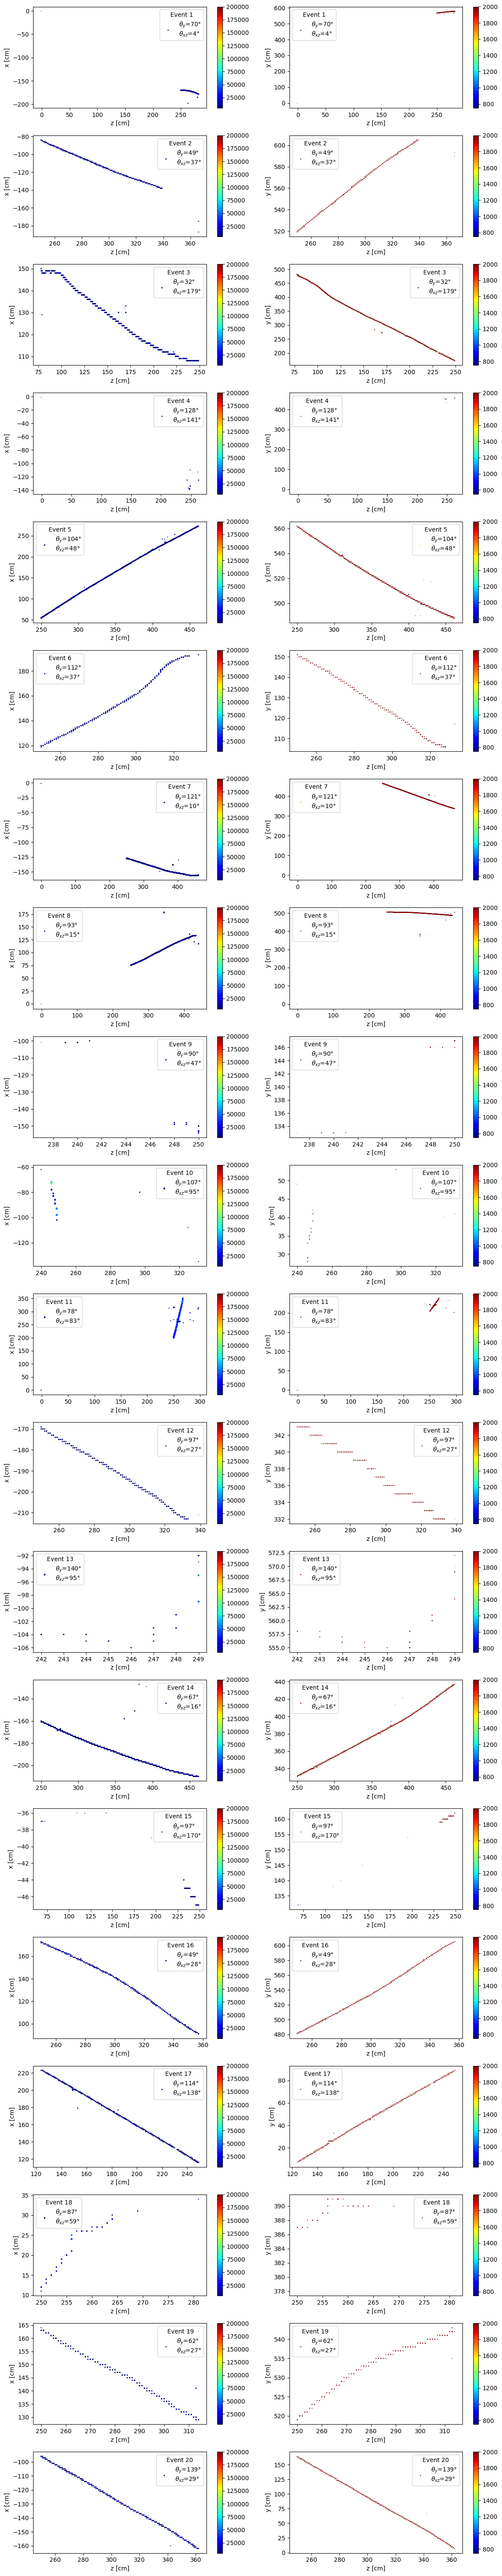

In [21]:
# plot beam events 
event_ids = tps.event.unique()[:20]

fig, axes = plt.subplots(len(event_ids), 2, figsize=(12, 3 * len(event_ids)))
if len(event_ids) == 1:
    axes = np.array([axes])

for i, event in enumerate(event_ids):
    Plot_orientation(axes[i], tps, mc, event)

plt.tight_layout()
plt.show()


If you want a 3D image for these simulation you can use this cell:

### <a id='toc1_5_2_'></a>[How do the width and the height of our signal change with the angular direction?](#toc0_)

In [22]:
angle_cols = ["theta_xz", "theta_y"]
tps = tps.merge(mc[["event"] + angle_cols], on="event", how="left")

properties = ["TP_TOT", "TP_SADC"]
angles = ["theta_xz", "theta_y"]  # angles in degrees for plotting

tps_coll = tps[
    (tps.TP_plane == COLLECTION_PLANE) &
    (tps["TP_TOT"] > 2) &
    (tps["TP_SADC"] >= 2500) &
    (tps["TP_SADC"] <= 20000)
]

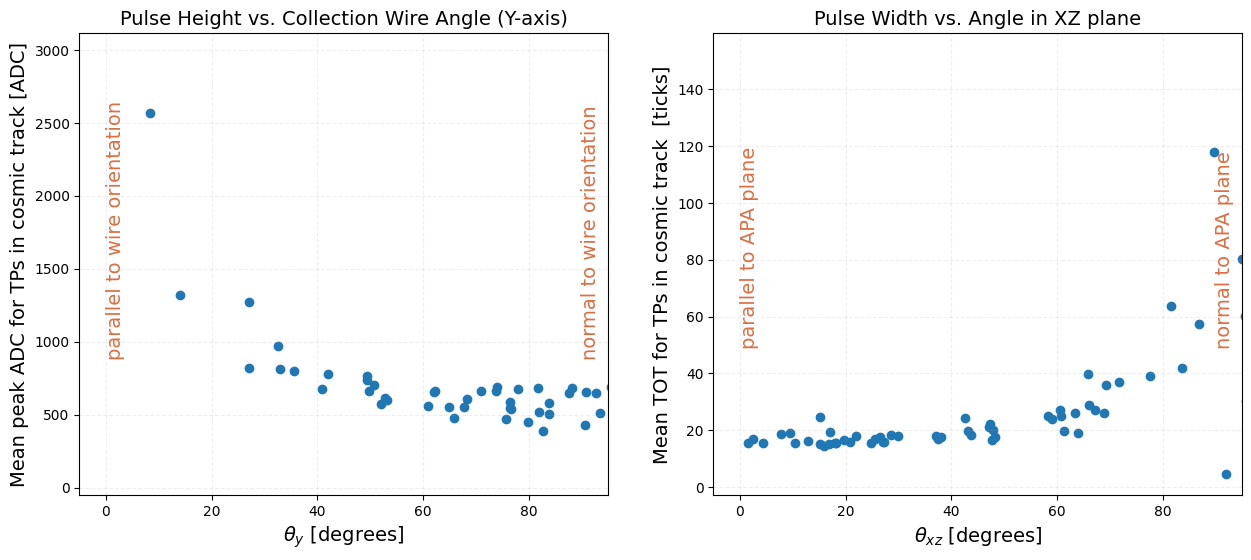

In [23]:

mc = mc[mc.event.isin(tp_plane2.event.unique())]

tp2_means = tp_plane2.groupby("event")[["TP_peakADC", "TP_TOT"]].mean().reset_index()
merged = pd.merge(tp2_means, mc, on='event', how='inner')

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Pulse Height vs. Collection Wire Angle (per event)
ax[0].set_title("Pulse Height vs. Collection Wire Angle (Y-axis)", fontsize=14)
ax[0].scatter(merged['theta_y'], merged['TP_peakADC'])
ax[0].set_xlabel(r"$\theta_y$ [degrees]", fontsize=14)
ax[0].set_ylabel("Mean peak ADC for TPs in cosmic track [ADC]", fontsize=14)
ax[0].text(0, 900, 'parallel to wire orientation', rotation=90, color='#DD6E42',fontsize=14)
ax[0].text(90, 900, 'normal to wire orientation', rotation=90, color='#DD6E42', fontsize=14)


# Right plot: Pulse Width vs. Angle in XZ plane (per event)
ax[1].set_title("Pulse Width vs. Angle in XZ plane", fontsize=14)
ax[1].scatter(merged['theta_xz'], merged['TP_TOT'])
ax[1].set_xlabel(r"$\theta_{xz}$ [degrees]", fontsize=14)
ax[1].set_ylabel("Mean TOT for TPs in cosmic track  [ticks]", fontsize=14)
ax[1].text(90, 50, 'normal to APA plane', rotation=90, color='#DD6E42', fontsize=14)
ax[1].text(0, 50, 'parallel to APA plane', rotation=90, color='#DD6E42', fontsize=14)

for i in [0, 1]:
    ax[i].grid(alpha=0.2, linestyle='dashed')
    ax[i].set_xlim(-5, 95)

plt.show()

- Y plane is the one the collection plane so it is normally associated with the charge 

- the other two axis are for the width of the pulse shape